# Import modules
CDC data set description link [here](https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?Component=Questionnaire&CycleBeginYear=2015)

In [34]:
import pdb
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, AdaBoostRegressor
from sklearn.svm import SVC
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

import nhanes as nhanes

%matplotlib notebook

## Settings

In [2]:
DATA_PATH = 'C:/Users/allen/Documents/Git-Repos/Opportunistic/CDC/NHANES/'
DATASET = 'cancer'

### Note: 
The code below loads each dataset: dataset_features, dataset_targets

Here, all datasets are defined explicitly (see nhanes.py).
*Caution* Very long computation, proceed with care

In [3]:
ds = nhanes.Dataset(DATA_PATH)
ds.load_cancer()
n_fe = ds.features.shape[1]
n_classes = 2

Processing: Questionnaire\SMQRTU_I.XPT                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

Processing: Examination\CSX_H.XPT                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

Processing: Laboratory\UC.XPTXPT                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

Processing: Questionnaire\WHQ_H.XPT                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

Extract the features and targets.

In [4]:
features = ds.features.values
targets = ds.targets.values

indx = np.argwhere(targets != 3)
dataset_features = features[indx.flatten()]
dataset_targets = targets[indx.flatten()]

dataset_features = pd.DataFrame(dataset_features, columns=ds.features.columns)
dataset_targets = pd.DataFrame(dataset_targets, columns=ds.targets.columns, dtype='float64')
print(dataset_targets.shape)
# Pre-fix
# dataset_features = ds.features
# dataset_targets = ds.targets

(98908, 1)


## Preprocessing of Data

### Calculate feature importance

In [5]:
dataset_features_sel = dataset_features.copy()
importances = []
num_trees = 5

for i in range(num_trees):
    clf = ExtraTreesClassifier(n_estimators=50)
    clf = clf.fit(dataset_features_sel.values, dataset_targets.values.ravel())
    importances.append(clf.feature_importances_)
    print('0% [',(i+1)*'.',(num_trees-i-1)*'-','] 100%', end='\r')

print('\nDone')

0% [ .....  ] 100%
Done


#### Drop Threshhold helper function

In [6]:
def drop_threshold(threshold, df_data, df_threshold):
    '''
    Sort a 1xn pandas dataframe df_data, return only 
    up to sum of threshold value indicies in df_threshhold
    if threshold is <= 1. If threshold >= 1, return the top 
    threshold number of columns.
    '''
    mi = df_threshold # mutual information dataframe
    df = df_data # data containing dataframe
    to_keep = []
    mi = mi.sort_values(by=0, axis=1, ascending=False) #sorts the values descending
    # print(mi)
    var_counter = 0
    col_counter = 0
    if(threshold <=1):
        for col in mi:
            var_counter += mi[col].iloc[0]
            col_counter += 1
            to_keep.append(col)
            if(var_counter >= threshold and threshold <= 1):
                break
            else if(col_counter >= threshold and threshold > 1):
                break
        if(len(to_keep) > 0):
            return pd.DataFrame(df[to_keep].copy(), dtype='float64')
        else:
            raise NotImplementedError

#### Drop low importance features

(98908, 84)


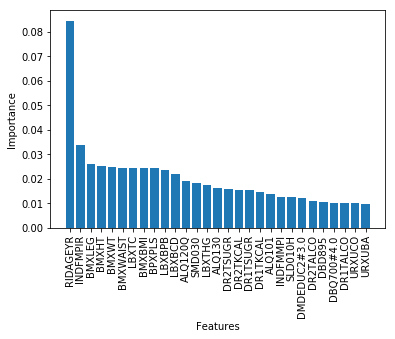

In [7]:
importances_mean = np.array(importances)
importances_mean = np.mean(importances_mean, axis=0)
importances_mean = importances_mean.reshape((1, len(importances_mean)))
importances_mean = pd.DataFrame(importances_mean, columns=ds.features.columns, dtype='float64')
importances_mean = importances_mean.sort_values(by=0, axis=1, ascending=False)

gfs = 29 # number features to show 
df_importances = drop_threshold(0.90, dataset_features_sel, importances_mean)
print(df_importances.shape)

# Visualize Importance:
idx = [i for i in range(len(importances_mean.columns))]
cols = [i for i in importances_mean.columns]
# print(importances_mean.values[0][0:gfs])
plt.bar(idx[0:gfs], importances_mean.values[0][0:gfs])
plt.xticks(idx[0:gfs], importances_mean.columns[0:gfs], rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()


#### Seperate one-hot encoded, discrete, and continuous features

In [8]:
# onehot encoded
dataset_features_onehot = df_importances.filter(regex=(".*#.*"))
# Continuous 
dataset_features_cont = df_importances.drop(columns=df_importances.filter(regex=(".*#.*")))


print("Original shape: %s" %(df_importances.shape,))
print("Continuous features shape: %s" %(dataset_features_cont.shape,))
print("Categorical features shape: %s "%(dataset_features_onehot.shape,))

Original shape: (98908, 84)
Continuous features shape: (98908, 43)
Categorical features shape: (98908, 41) 


#### Calculate PCA to drop features

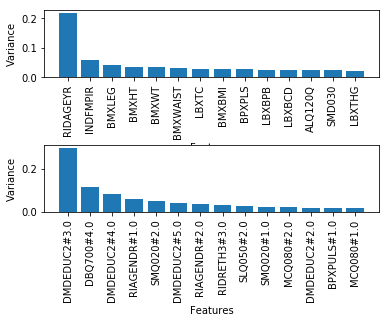

In [9]:
# dfs = [dataset_features_cont.copy(), dataset_features_disc.copy(), dataset_features_onehot.copy()]
dfs_out = [dataset_features_cont.copy(), dataset_features_onehot.copy()]
pca_dfs = []
gfs = 15 # Number of features to graph
gfs -= 1
i = 0
for df in dfs_out:    
#     print(df.shape)
    pca = PCA() # no args, so keep all columns, n_components=2
    pca.fit(df)
    var_ratio = pca.explained_variance_ratio_
    var_ratio = var_ratio.reshape((1, len(var_ratio)))
    pca_dfs.append(pd.DataFrame(data=var_ratio, columns=df.columns))
    # Visualize PCA:
    idx = [i for i in range(len(df.columns))]
    cols = [i for i in df.columns]
    plt.subplot(len(dfs_out),1,i+1)
    plt.subplots_adjust(hspace = 1, top=1, bottom=.3)
    plt.bar(idx[0:gfs], pca.explained_variance_ratio_[0:gfs])
    plt.xticks(idx[0:gfs], df.columns[0:gfs], rotation='vertical')
    plt.xlabel('Features')
    plt.ylabel('Variance')
    i+=1
plt.show()

# print(pca_dfs.shape)


#### Remove columns that account for too little of the variance

In [17]:
pca_dfs_out = []

for i in range(len(dfs_out)):
    pca_dfs_out.append(drop_threshold(.8, dfs_out[i] ,pca_dfs[i]))

for df in pca_dfs_out:
    print(df.shape)

df_final = pd.concat(pca_dfs_out, axis=1)
print(df_final.shape)

print('\nFinal list is %s features' %(df_final.shape[1]))
print(df_final.columns)
# for i in df_final.columns:
#     print(i)

(98908, 23)
(98908, 12)
(98908, 35)

Final list is 35 features
Index(['RIDAGEYR', 'INDFMPIR', 'BMXLEG', 'BMXHT', 'BMXWT', 'BMXWAIST', 'LBXTC',
       'BMXBMI', 'BPXPLS', 'LBXBPB', 'LBXBCD', 'ALQ120Q', 'SMD030', 'LBXTHG',
       'ALQ130', 'DR2TSUGR', 'DR2TKCAL', 'DR1TSUGR', 'DR1TKCAL', 'ALQ101',
       'INDFMMPI', 'SLD010H', 'DR2TALCO', 'DMDEDUC2#3.0', 'DBQ700#4.0',
       'DMDEDUC2#4.0', 'RIAGENDR#1.0', 'SMQ020#2.0', 'DMDEDUC2#5.0',
       'RIAGENDR#2.0', 'RIDRETH3#3.0', 'SLQ050#2.0', 'SMQ020#1.0',
       'MCQ080#2.0', 'DMDEDUC2#2.0'],
      dtype='object')


## Train/Test Separation

In [19]:
perm = np.random.permutation(dataset_targets.shape[0])
dataset_targets_vals = np.ravel(dataset_targets.values) # unroll the column to the correct vector shape

dataset_features = df_final.values[perm]
dataset_targets = dataset_targets_vals[perm]

print("dataset_features Shape: %s, dataset_targets Shape: %s" % (dataset_features.shape, dataset_targets.shape))

def get_batch(n_size, phase):
    # select indices
    n_samples = dataset_features.shape[0]
    n_classes = int(dataset_targets.max() + 1)
    if phase == 'test':
        inds_sel = np.arange(0, int(n_samples*0.15), 1)
    elif phase == 'validation':
        n_samples = dataset_features.shape[0]
        inds_sel = np.arange(int(n_samples*0.15), int(n_samples*0.30), 1)
    elif phase == 'train':
        n_samples = dataset_features.shape[0]
        inds_sel = np.arange(int(n_samples*0.30), n_samples, 1)
    else:
        raise NotImplementedError
    inds_sel = np.random.permutation(inds_sel)
    batch_inds = []
    for cl in range(n_classes):
        inds_cl = inds_sel[dataset_targets[inds_sel] == cl]
        batch_inds.extend(inds_cl[:n_size//n_classes])
    batch_inds = np.random.permutation(batch_inds)
    
    return dataset_features[batch_inds], dataset_targets[batch_inds]

dataset_features Shape: (98908, 35), dataset_targets Shape: (98908,)


## Validation
First run for all options

In [24]:
# Create first pipeline for base without reducing features.
did_search = True
if not did_search:
    pipe = Pipeline([('classifier' , RandomForestClassifier())])

    # Create param grid.

    param_grid = [
        {'classifier' : [LogisticRegression()],
         'classifier__penalty' : ['l1', 'l2'],
         'classifier__solver' : ['liblinear'],
        'classifier__C' : np.logspace(-4, 4, 20)} #,
        {'classifier' : [RandomForestClassifier()],
        'classifier__n_estimators' : list(range(10,101,10)),
        'classifier__max_features' : list(range(2,32,5))},
        {'classifier' : [SVC()],
         'classifier__kernel':('linear', 'rbf'),
         'classifier__gamma' : ['auto', 'scale'],
         'classifier__C':[0.001, 0.01, 0.1, 1, 10]},
        {'classifier' : [AdaBoostClassifier()],
         'classifier__base_estimator':[LogisticRegression(), DecisionTreeClassifier()]}
    ]

    # Create grid search object

    clf_all = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
    # Fit on data
    features_val, targets_val = get_batch(n_size=10000, phase='validation')
    best_clf_all = clf_all.fit(features_val, targets_val)
    print(clf_all.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   25.9s finished


{'classifier': LogisticRegression(C=0.23357214690901212, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), 'classifier__C': 0.23357214690901212, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}


*The Results:*
{'classifier': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=22, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), 'classifier__max_features': 22, 'classifier__n_estimators': 20}

**Then run for LR and then Adaboost**

In [45]:
did_search = False
best_clf_lr, clf_lr = None
if not did_search:

    # Create param grid.

    param_grid = [
        {'penalty' : ['l1', 'l2'],
         'solver' : ['liblinear'],
         'C' : np.logspace(-4, 4, 20)}
    ]

    # Create grid search object

    clf_lr = GridSearchCV(LogisticRegression(), param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
    # Fit on data
    features_val, targets_val = get_batch(n_size=10000, phase='validation')
    best_clf_lr = clf_lr.fit(features_val, targets_val)
    print(clf_lr.best_params_) # {'C': 0.08858667904100823, 'penalty': 'l1', 'solver': 'liblinear'}

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 106 tasks      | elapsed:    5.8s


{'C': 0.08858667904100823, 'penalty': 'l1', 'solver': 'liblinear'}


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   16.9s finished


In [46]:
did_search = False
best_clf, clf = None
if not did_search:
   # Create param grid.

    param_grid = [
        {'base_estimator':[clf_lr.best_estimator_, DecisionTreeClassifier()],
        'n_estimators' : list(range(10,101,10)),
        'loss' : ['linear', 'square', 'exponential']}
    ]

    # Create grid search object

    clf = GridSearchCV(AdaBoostRegressor(), param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
    # Fit on data
    features_val, targets_val = get_batch(n_size=10000, phase='validation')
    best_clf = clf.fit(features_val, targets_val)
    print(clf.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.8min finished


{'base_estimator': LogisticRegression(C=0.08858667904100823, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), 'loss': 'linear', 'n_estimators': 40}


## Classification

In [65]:
# AdaboostRegressor
features_trn, targets_trn = get_batch(n_size=5000, phase='train')
features_tst, targets_tst = get_batch(n_size=1000, phase='test')
clf_adb = None
# if(clf is None):
base = LogisticRegression(C=0.08858667904100823, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
clf_adb = AdaBoostRegressor(base_estimator=base, n_estimators=40, loss='linear')
# else:
#     clf_adb = clf.best_estimator_
    
base.fit(features_trn, targets_trn)
preds_tst = base.predict(features_tst)
accu = np.mean(preds_tst==targets_tst)
print('accu_tst_ADB', accu)
print(classification_report(targets_tst, preds_tst))

accu_tst_ADB 0.839
              precision    recall  f1-score   support

         0.0       0.81      0.89      0.85       500
         1.0       0.88      0.79      0.83       500

   micro avg       0.84      0.84      0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000



In [26]:
trials = 10
accu_tst_RFC = []
accu_tst_SVC = []
accu_tst_LR = []

for i in range(trials):
    features_trn, targets_trn = get_batch(n_size=5000, phase='train')
    features_tst, targets_tst = get_batch(n_size=1000, phase='test')

    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=22, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
    clf.fit(features_trn, targets_trn)
    preds_tst = clf.predict(features_tst)
    accu = np.mean(preds_tst==targets_tst)
    # print('accu_tst_RFC', accu)
    accu_tst_RFC.append(accu)

    clf = SVC(gamma='auto')
    clf.fit(features_trn, targets_trn)
    preds_tst = clf.predict(features_tst)
    accu = np.mean(preds_tst==targets_tst)
    # print('accu_tst_SVC', accu)
    accu_tst_SVC.append(accu)

#     clf = LogisticRegression(solver='lbfgs', max_iter=200, multi_class='auto')
    clf = LogisticRegression(C=0.23357214690901212, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
    clf.fit(features_trn, targets_trn)
    preds_tst = clf.predict(features_tst)
    accu = np.mean(preds_tst==targets_tst)
    # print('accu_tst_LR', accu)
    accu_tst_LR.append(accu)
    print('0% [',(i+1)*'.',(trials-i-1)*'-','] 100%', end='\r')
    
accu_tst_RFC = np.array(accu_tst_RFC)
accu_tst_SVC = np.array(accu_tst_SVC)
accu_tst_LR = np.array(accu_tst_LR)

print("\nDone")

0% [ ..........  ] 100%
Done


In [27]:
print(classification_report(targets_tst, preds_tst))

print('\nAverage accuracies after %s random trials:' %(trials))
print('accu_tst_RFC %.3f, accu_tst_SVC %.3f, accu_tst_LR %.3f'
      % (np.mean(accu_tst_RFC), np.mean(accu_tst_SVC), np.mean(accu_tst_LR)))

print('\nMax accuracies after %s random trials:' %(trials))
print('accu_tst_RFC %.3f, accu_tst_SVC %.3f, accu_tst_LR %.3f'
      % (np.max(accu_tst_RFC), np.max(accu_tst_SVC), np.max(accu_tst_LR)))

              precision    recall  f1-score   support

         0.0       0.79      0.87      0.83       500
         1.0       0.86      0.77      0.81       500

   micro avg       0.82      0.82      0.82      1000
   macro avg       0.83      0.82      0.82      1000
weighted avg       0.83      0.82      0.82      1000


Average accuracies after 10 random trials:
accu_tst_RFC 0.822, accu_tst_SVC 0.826, accu_tst_LR 0.836

Max accuracies after 10 random trials:
accu_tst_RFC 0.841, accu_tst_SVC 0.834, accu_tst_LR 0.851


### Accuracies from baseline: 
#### Cancer (ds.load_cancer()):
* accu_tst_RFC 0.758
* accu_tst_SVC 0.759
* accu_tst_LR 0.768

In [ ]:
# Adaboost
features_trn, targets_trn = get_batch(n_size=5000, phase='train')
features_tst, targets_tst = get_batch(n_size=1000, phase='test')
clf = AdaBoostClassifier(n_estimators=100)
clf.fit(features_trn, targets_trn)
preds_tst = clf.predict(features_tst)
accu = np.mean(preds_tst==targets_tst)
print('accu_tst_ADB', accu)

### Calculate mutual information
*Caution* Very long computation, proceed with care
Note: disused because of enmormous memory requirements

In [ ]:
# dataset_features_sel_vals = dataset_features_sel.values
# dataset_targets_vals = np.ravel(dataset_targets.values) # unroll the column to the correct vector shape
# # dfs = [dataset_features_cont.copy(), dataset_features_disc.copy(), dataset_features_onehot.copy()]
# # retrieve values from dfs_out for subsequent steps if this comes after PCA
# # dataset_features_cont = dfs_out[0]
# # dataset_features_disc = dfs_out[1]
# # dataset_features_onehot = dfs_out[2]

# print('0% [---] 100%', end='\r')
# mutual_info_cont = mutual_info_regression(dataset_features_cont.values, dataset_targets_vals)
# print('0% [+--] 100%', end='\r')
# # mutual_info_disc = mutual_info_regression(dataset_features_disc.values, dataset_targets_vals)
# # print('0% [++-] 100%', end='\r')
# mutual_info_onehot = mutual_info_classif(dataset_features_onehot.values, dataset_targets_vals)
# print('0% [+++] 100%', end='\r')

### Convert mutual info into dataframes and inspect

In [ ]:
# if(mutual_info_cont.shape[0] != 1): # we only need to run this portion of the block once
#     mutual_info_cont = mutual_info_cont.reshape((1, len(mutual_info_cont)))
#     mutual_info_disc = mutual_info_disc.reshape((1, len(mutual_info_disc))) 
#     mutual_info_onehot = mutual_info_onehot.reshape((1, len(mutual_info_onehot))) 


# mutual_info_cont_df = pd.DataFrame(data=mutual_info_cont, columns=dataset_features_cont.columns)
# mutual_info_disc_df = pd.DataFrame(data=mutual_info_disc, columns=dataset_features_disc.columns)
# mutual_info_onehot_df = pd.DataFrame(data=mutual_info_onehot, columns=dataset_features_onehot.columns)

### Dropping features with low mutual information
    __Conditioned on target variable__

In [ ]:
# mi_dfs = [mutual_info_cont_df, mutual_info_disc_df, mutual_info_onehot_df]
# dfs = [dataset_features_cont, dataset_features_disc, dataset_features_onehot]
# dfs_out = []

# for i in range(len(dfs)):
#     mi = mi_dfs[i] # mutual information dataframe
#     df = dfs[i] # data containing dataframe
#     to_drop = []
#     mean = 0.25*mi.mean(axis=1)
    
#     # mi = mi.sort_values(by =0, axis=1) #sorts the values ascending
#     # print(mi)
#     for col in mi:
#         if(mi[col].iloc[0] < mean).all():
#             to_drop.append(col)
#     if(len(to_drop) > 0):
#         dfs_out.append(pd.DataFrame(df.drop(columns=to_drop)))
    
# dfs_out = pd.concat(dfs_out, axis=1)
# # Retained columns
# print(dfs_out.columns)
# # output shape
# print(dfs_out.shape)